# Using our Model

This notebook was loaded with:

```bash
PYSPARK_DRIVER_PYTHON=jupyter PYSPARK_DRIVER_PYTHON_OPTS=notebook ./dse/bin/dse pyspark --num-executors 5 --driver-memory 8g --executor-memory 8g
```

In [1]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [50]:
from pyspark.sql.functions import col
from pyspark.ml.classification import  LogisticRegressionModel, GBTClassificationModel
from pyspark.ml.feature import VectorIndexer, VectorAssembler, StringIndexer
from pyspark.ml import Pipeline
import pyspark

from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import datetime

# Testing how we did

The last_60 set we set aside earlier is a simulation of how we would have done if we used the model to predict. let's load that.

In [3]:
df = sqlContext.read.format('parquet').load('last_60_set')

In [4]:
df.dtypes

[('inspection_dt', 'date'),
 ('city_grid', 'int'),
 ('y', 'int'),
 ('y_fail', 'int'),
 ('canvass', 'int'),
 ('complaint', 'int'),
 ('cumulative_failures', 'int'),
 ('cumulative_inspections', 'int'),
 ('days_since_last_inspection', 'int'),
 ('ever_failed', 'int'),
 ('inspection_type', 'int'),
 ('license_related', 'int'),
 ('liquor', 'int'),
 ('prev_fail', 'int'),
 ('proportion_past_failures', 'double'),
 ('recent_inspection', 'int'),
 ('reinspection', 'int'),
 ('special_event', 'int'),
 ('task_force', 'int'),
 ('monthVec', 'vector'),
 ('weekdayVec', 'vector'),
 ('riskVec', 'vector'),
 ('wardVec', 'vector'),
 ('police_districtVec', 'vector'),
 ('conditional_approval', 'int'),
 ('crime_count_theft', 'bigint'),
 ('crime_count_burglary', 'bigint'),
 ('crime_count_other', 'bigint'),
 ('sanitation_violation_count', 'bigint'),
 ('TMAX', 'int'),
 ('TMIN', 'int'),
 ('TMAX_3', 'double'),
 ('TMAX_5', 'double')]

In [5]:
df = df.drop("city_grid").drop("y")

In [6]:
df.count()

1265

# Preparing the  Model

We've got a little work to do to get spark.ml to be able to process our data. First, we'll index the label (our actual pass/fail) that we're training on. This process is the same as before.

In [7]:
labelIndexer = StringIndexer(inputCol="y_fail", outputCol="label")

Next, we'll record our columns. We'll use one for the indexing the features. Remember when we one-hot encoded a few columns? We'll need another list of columns so that we can decode them back (the second array). We could broadcast these, but we'll keep it simple since this training is a one-time thing.

In [8]:
#broadcast this?
feature_cols = ['canvass',
 'complaint',
 'cumulative_failures',
 'cumulative_inspections',
 'days_since_last_inspection',
 'ever_failed',
 'inspection_type',
 'license_related',
 'liquor',
 'prev_fail',
 'proportion_past_failures',
 'recent_inspection',
 'reinspection',
 'special_event',
 'task_force',
 'monthVec',
 'weekdayVec',
 'riskVec',
 'conditional_approval',
 'wardVec',
 'police_districtVec',
 'crime_count_theft',
 'crime_count_burglary',
 'crime_count_other',
 'sanitation_violation_count',
 'TMAX',
 'TMIN',
 'TMAX_3',
 'TMAX_5']

In [9]:
full_feature_set = [
   'canvass',
 'complaint',
 'cumulative_failures',
 'cumulative_inspections',
 'days_since_last_inspection',
 'ever_failed',
 'inspection_type',
 'license_related',
 'liquor',
 'prev_fail',
 'proportion_past_failures',
 'recent_inspection',
 'reinspection',
 'special_event',
 'task_force',
 'month_jan','month_feb','month_march','month_april','month_may','month_june','month_july','month_august','month_sept','month_oct','month_nov','month_dec',
 'weekday_mon','weekday_tues','weekday_weds','weekday_thurs','weekday_fri','weekday_sat',
 'risk_high','risk_med','risk_low',
 'conditional_approval',
 'ward_1',
 'ward_2',
 'ward_3',
 'ward_4',
 'ward_5',
 'ward_6',
 'ward_7',
 'ward_8',
 'ward_9',
 'ward_10',
 'ward_11',
 'ward_12',
 'ward_13',
 'ward_14',
 'ward_15',
 'ward_16',
 'ward_17',
 'ward_18',
 'ward_19',
 'ward_20',
 'ward_21',
 'ward_22',
 'ward_23',
 'ward_24',
 'ward_25',
 'ward_26',
 'ward_27',
 'ward_28',
 'ward_29',
 'ward_30',
 'ward_31',
 'ward_32',
 'ward_33',
 'ward_34',
 'ward_35',
 'ward_36',
 'ward_37',
 'ward_38',
 'ward_39',
 'ward_40',
 'ward_41',
 'ward_42',
 'ward_43',
 'ward_44',
 'ward_45',
 'ward_46',
 'ward_47',
 'ward_48',
 'ward_49', 'ward_50','district_1',
 'district_2',
 'district_3',
 'district_4',
 'district_5',
 'district_6',
 'district_7',
 'district_8',
 'district_9',
 'district_10',
 'district_11',
 'district_12',
 'district_13',
 'district_14',
 'district_15',
 'district_16',
 'district_17',
 'district_18',
 'district_19',
 'district_20',
 'district_21',
 'district_22',
 'district_23',
 'district_24', 'district_25',
 'crime_count_theft',
 'crime_count_burglary',
 'crime_count_other',
 'sanitation_violation_count',
 'TMAX',
 'TMIN',
 'TMAX_3',
 'TMAX_5' 
]

Now, we assemble our feature columns into a single Sparse Vector (https://spark.apache.org/docs/1.1.0/mllib-data-types.html)

In [11]:
featureAssembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

A pipeline is used to compose our functions. Remember that Spark doesn't execute these until an action is taken... that will be `fit` below

In [12]:
pipeline = Pipeline(stages=[featureAssembler, labelIndexer])

In [13]:
data = pipeline.fit(df).transform(df)
data.cache()

DataFrame[inspection_dt: date, y_fail: int, canvass: int, complaint: int, cumulative_failures: int, cumulative_inspections: int, days_since_last_inspection: int, ever_failed: int, inspection_type: int, license_related: int, liquor: int, prev_fail: int, proportion_past_failures: double, recent_inspection: int, reinspection: int, special_event: int, task_force: int, monthVec: vector, weekdayVec: vector, riskVec: vector, wardVec: vector, police_districtVec: vector, conditional_approval: int, crime_count_theft: bigint, crime_count_burglary: bigint, crime_count_other: bigint, sanitation_violation_count: bigint, TMAX: int, TMIN: int, TMAX_3: double, TMAX_5: double, features: vector, label: double]

In [21]:
def reportAccuracy(metrics):
    print metrics.accuracy
    matrix = metrics.confusionMatrix().toArray()
    print matrix
    plt.figure(figsize = (3,3))
    sns.heatmap(matrix, annot=True, fmt="g")
    plt.xlabel("True")
    plt.ylabel("Predicted")

In [19]:
def reportResults(rdd, model):
    fig = plt.figure(figsize=(12, 4))
    ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
    ax2= plt.subplot2grid((1, 5), (0, 3), colspan=3)
    
    metrics = MulticlassMetrics(rdd)

    print metrics.accuracy
    matrix = metrics.confusionMatrix().toArray()
    print matrix
    
    sns.heatmap(matrix, annot=True, fmt="g", ax=ax1)
    ax1.set_xlabel("True")
    ax1.set_ylabel("Predicted")

    # Include only the 10 most important predictors
    df_importance = pd.DataFrame(model.featureImportances.toArray())
    df_importance.columns = ["importance"]
    df_importance["names"] = full_feature_set
    
    df_importance.sort_values("importance", ascending=False, inplace=True)
    df_importance = df_importance.head(10)
    ax2.barh(range(1,11),df_importance["importance"],align='center', color = "darkblue", alpha = 0.6)
    ax2.set_yticklabels(df_importance["names"])
    ax2.set_yticks(range(1,11))
    ax2.set_xlabel('Relative Importance in the Model')
    ax2.set_ylabel('Features')
    ax2.set_title('Relative importance of Each Feature')

# Logistic Regression

The model still looks pretty good.

In [16]:
model = LogisticRegressionModel.load("final_model_lr")

In [17]:
predictions_lr = model.transform(data)

0.8395256917
[[ 976.    7.]
 [ 196.   86.]]


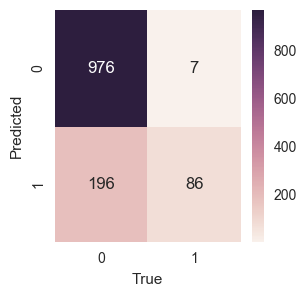

In [22]:
metrics = MulticlassMetrics(predictions_lr.select("prediction", "label").rdd)
reportAccuracy(metrics)

# Gradient Boosted Trees

For fun, let's see how the GBT did..

In [23]:
gbt = GBTClassificationModel.load("final_model")

0.873517786561
[[ 950.   33.]
 [ 127.  155.]]


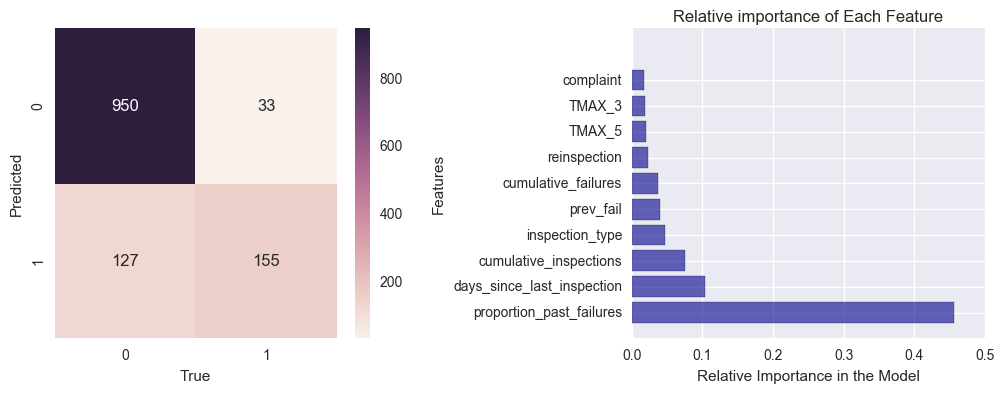

In [24]:
predictions_gbt = gbt.transform(data)
reportResults(predictions_gbt.select("prediction", "label").rdd, gbt)

# Comparing and Preparing inspections

I still like logistic regression better. Let's create an inspection list and score them properly. We'll sort them and use 2 metrics.

- How many days on average fails were caught sooner
- How many were caught in the first month (that way the averages won't hide outliers).

In [25]:
def score_delta_days(predicted):
    deltas = (predicted.assigned_dt - predicted.inspection_dt).dt.days
    return np.mean(deltas)

In [62]:

#this will sort by proba 0, then assign in order by max per day inspections
#the average in the actual set was 30/day. We'll go with that as capacity.
def assign_lr(df1):
    capacity = 30
    
    df1["probability_y_1"] = df1["probability"].str[1]

    df_sorted = df1.sort_values(by='probability_y_1', ascending=[0])
    
    dates = []

    for o in range(736208,736269): #ordinals for 9/1 to 10/31
        dates.append(datetime.date.fromordinal(o))
    
    j=0
    k=0
    for i,item in df_sorted.iterrows():
        df_sorted.ix[i, "assigned_dt"] = dates[k]
    
        j = j+1
    
        if j > 30: #max allowed per day
            j = 1 #reset the counter

            if k < len(dates) - 1:
                k = k + 1 #move to next day
    
    df_sorted["assigned_dt"] = df_sorted["assigned_dt"].astype('datetime64[ns]')
    return df_sorted

In [66]:

#this will sort by proba 0, then assign in order by max per day inspections
#the average in the actual set was 30/day. We'll go with that as capacity.
def assign_tree(df1):
    capacity = 30
    df_sorted = df1.sort_values(by='proportion_past_failures', ascending=[0])
    
    dates = []

    for o in range(736208,736269): #ordinals for 9/1 to 10/31
        dates.append(datetime.date.fromordinal(o))
    
    j=0
    k=0
    for i,item in df_sorted.iterrows():
        df_sorted.ix[i, "assigned_dt"] = dates[k]
    
        j = j+1
    
        if j > 30: #max allowed per day
            j = 1 #reset the counter

            if k < len(dates) - 1:
                k = k + 1 #move to next day
    
    df_sorted["assigned_dt"] = df_sorted["assigned_dt"].astype('datetime64[ns]')
    return df_sorted

In [52]:
#predictions_lr.withColumn("prob_y_1", col("probability")[1])

In [63]:
assigned_lr = assign_lr(predictions_lr.toPandas())

In [67]:
assigned_tree = assign_tree(predictions_gbt.toPandas())

In [69]:
assigned_tree["inspection_dt"] = assigned_tree["inspection_dt"].astype('datetime64[ns]')
assigned_lr["inspection_dt"] = assigned_lr["inspection_dt"].astype('datetime64[ns]')

In [70]:
tree_score1 = score_delta_days(assigned_tree)

In [71]:
lr_score1 = score_delta_days(assigned_lr)

In [79]:
print "Number of days failures caught earlier (on average) than current process."
print "LR %.2f, GBT %.2f" % (lr_score1, tree_score1)

Number of days failures caught earlier (on average) than current process.
LR -5.46, GBT -5.46


In [80]:
#Another way to measure is the proportion of actual 
#failures caught in the first 30 days
def score_prop_first(predicted):    
    predicted_first_month = predicted[predicted.assigned_dt.dt.month == 9]
    
    overlap = predicted_first_month[predicted_first_month["y_fail"] == 1]["y_fail"].count()

    return overlap/float(predicted.shape[0])

In [81]:
tree_score2 = score_prop_first(assigned_tree)

In [82]:
lr_score2 = score_prop_first(assigned_lr)

In [84]:
print "Proportion Caught in the first 1/2 of the inspection cycle"
print "LR %.2f, TREE %.2f" % (lr_score2, tree_score2)

Proportion Caught in the first 1/2 of the inspection cycle
LR 0.22, TREE 0.22


In [85]:
df_score1 = pd.DataFrame()
df_score1["Scores"] = [lr_score1, tree_score1]
df_score1["Models"] = ['LR', 'GBT']

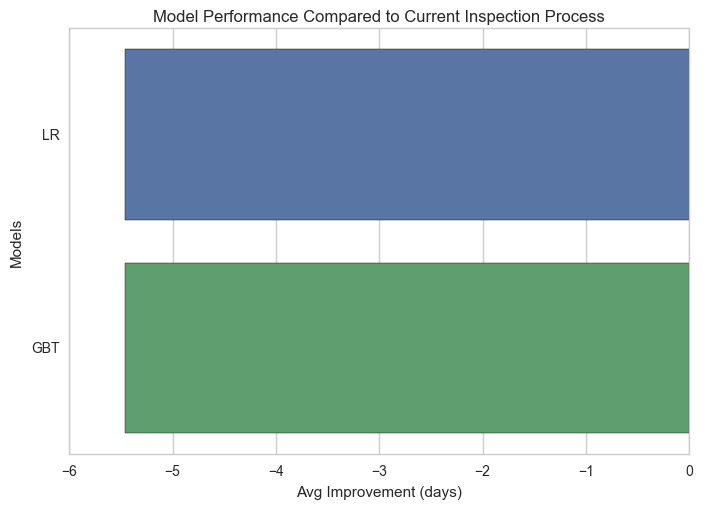

In [86]:

sns.set_style("whitegrid")
ax = sns.barplot(x="Scores", y="Models", data=df_score1)
ax.set(xlabel="Avg Improvement (days)", ylabel="Models")
ax.set_title("Model Performance Compared to Current Inspection Process")

Hm. Exactly the same. let's see the other score.

In [87]:
df_score2 = pd.DataFrame()
df_score2["Scores"] = [lr_score2, tree_score2]
df_score2["Models"] = ['LR', 'GBT']

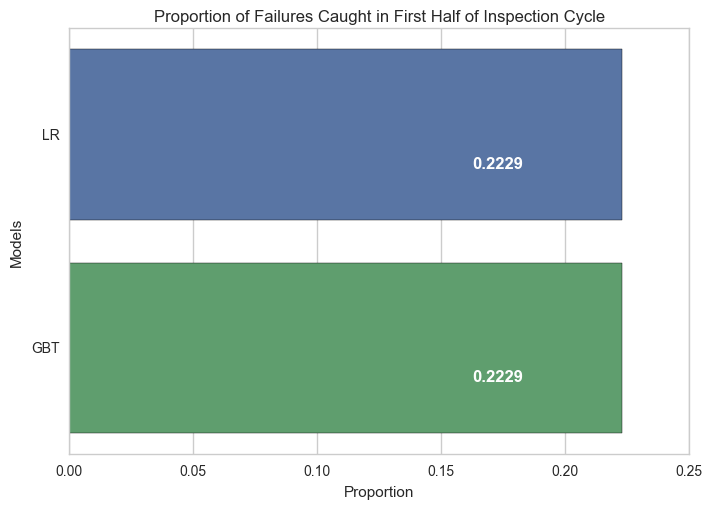

In [88]:
sns.set_style("whitegrid")
ax = sns.barplot(x="Scores", y="Models", data=df_score2)
ax.set(xlabel="Proportion", ylabel="Models")
ax.set_title("Proportion of Failures Caught in First Half of Inspection Cycle")

for n, (_x, label) in enumerate(zip(df_score2["Scores"], df_score2["Models"])):
    ax.annotate(
        s='{:.4f}'.format(abs(_x)),
        xy=(_x - .05, n + .2),
        ha='center',va='center',
        xytext=(0,10),
        color='white',
        textcoords='offset points',
        weight='bold'
    )

ok! Well, what can we say? Both models performed about the same in practicality. While one predicted certain values better than the other, in reality, they both had about the same practical predictive power on this unseen set. What are the odds? It does make some sense in that if previous failures played a strong role in both models, they would both be primarily driven by them. Ultimately, we're not terribly conclusive... we'll need to keep looking at how it goes in subsequent months.

In [89]:
assigned_lr.head()

,inspection_dt,y_fail,canvass,complaint,cumulative_failures,cumulative_inspections,days_since_last_inspection,ever_failed,inspection_type,license_related,...,TMIN,TMAX_3,TMAX_5,features,label,rawPrediction,probability,prediction,probability_y_1,assigned_dt
175,2016-10-18,1,0,0,1,1,0,1,2,1,...,60,69.75,66.833333,"(0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, ...",1.0,"[-0.334770336642, 0.334770336642]","[0.417080381487, 0.582919618513]",1.0,0.58292,2016-09-01
66,2016-09-20,1,0,0,1,1,0,1,2,1,...,67,79.75,79.000000,"(0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, ...",1.0,"[-0.334770336642, 0.334770336642]","[0.417080381487, 0.582919618513]",1.0,0.58292,2016-09-01
705,2016-09-27,1,0,0,1,1,0,1,2,1,...,55,74.00,75.500000,"(0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, ...",1.0,"[-0.334770336642, 0.334770336642]","[0.417080381487, 0.582919618513]",1.0,0.58292,2016-09-01
926,2016-09-01,1,0,0,1,1,0,1,2,1,...,63,78.25,79.333333,"(0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, ...",1.0,"[-0.334770336642, 0.334770336642]","[0.417080381487, 0.582919618513]",1.0,0.58292,2016-09-01
925,2016-09-01,1,0,0,1,1,0,1,2,1,...,63,78.25,79.333333,"(0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, ...",1.0,"[-0.334770336642, 0.334770336642]","[0.417080381487, 0.582919618513]",1.0,0.58292,2016-09-01


In [90]:
assigned_tree.head()

,inspection_dt,y_fail,canvass,complaint,cumulative_failures,cumulative_inspections,days_since_last_inspection,ever_failed,inspection_type,license_related,...,crime_count_other,sanitation_violation_count,TMAX,TMIN,TMAX_3,TMAX_5,features,label,prediction,assigned_dt
175,2016-10-18,1,0,0,1,1,0,1,2,1,...,3559,694,76,60,69.75,66.833333,"(0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, ...",1.0,1.0,2016-09-01
66,2016-09-20,1,0,0,1,1,0,1,2,1,...,63347,8000,77,67,79.75,79.000000,"(0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, ...",1.0,1.0,2016-09-01
705,2016-09-27,1,0,0,1,1,0,1,2,1,...,35715,3363,70,55,74.00,75.500000,"(0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, ...",1.0,1.0,2016-09-01
926,2016-09-01,1,0,0,1,1,0,1,2,1,...,38993,4060,73,63,78.25,79.333333,"(0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, ...",1.0,1.0,2016-09-01
925,2016-09-01,1,0,0,1,1,0,1,2,1,...,38993,4060,73,63,78.25,79.333333,"(0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, ...",1.0,1.0,2016-09-01


There is probably something else worth saying... these models were not chosen at random. They were chosen to illustrate that both are good models, and that they both meet our objective. It's a happy coincidence that they are exactly the same results on this run. Additionally, the parameters weren't blindly chosen, either. A GridSearch was performed to tune each of the models, and where necessary, hyperparameters reflect that. In many cases, not using the default values offered so little loss that it was deemed better not to conceptually clutter the model.